In [1]:
import torch
import numpy as np
import logging
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from datasets import load_dataset
from tqdm import tqdm
import sys
import shap

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),
        logging.FileHandler('evaluation.log')
    ]
)
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

model_name = "facebook/wav2vec2-base-960h"
num_samples = 1  # Number of samples for SHAP background

/home/hagen/SHAP-Transformer-ASR/.shaptransformerasr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-08 16:40:49.513540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 16:40:49.587138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757342449.631773   58391 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757342449.647154   58

2025-09-08 16:40:53,334 - INFO - Using device: cuda


In [2]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        # Ensure input has correct shape for the model
        if len(x.shape) == 4:
            x = x.squeeze(1).squeeze(1)  # Remove extra dimensions
        elif len(x.shape) == 3:
            x = x.squeeze(1)  # Remove extra dimension
        
        # Add attention mask
        attention_mask = torch.ones_like(x)
        
        # Forward pass with attention mask
        logits = self.model(x, attention_mask=attention_mask).logits
        
        # Log the shape and statistics of logits
        logger.debug(f"Logits shape: {logits.shape}")
        logger.debug(f"Logits mean: {torch.mean(logits).item():.6f}")
        logger.debug(f"Logits std: {torch.std(logits).item():.6f}")
        
        # For SHAP, aggregate over vocab to get a scalar per time step
        return torch.max(logits, dim=-1).values # [batch, seq_len]

In [3]:
# Load model and processor
logger.info(f"Loading model: {model_name}")
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)
model = model.to(device)
logger.info("Model loaded successfully")

2025-09-08 16:40:53,393 - INFO - Loading model: facebook/wav2vec2-base-960h


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-09-08 16:40:53,252 - INFO - Model loaded successfully


In [4]:
# Create model wrapper for SHAP
wrapped_model = ModelWrapper(model)
logger.info("Model wrapper created")

2025-09-08 16:40:53,259 - INFO - Model wrapper created


In [5]:
def add_noise(audio: np.ndarray, snr_db: float) -> np.ndarray:
    """Add white noise to audio at specified SNR"""
    signal_power = np.mean(audio ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio))
    return audio + noise

In [ ]:
logger.info(f"Creating test set with {num_samples} samples")
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
test_set = []

for i in tqdm(range(min(num_samples, len(ds))), desc="Creating test samples"):
    sample = ds[i]
    audio = sample["audio"]["array"]
    text = sample["text"]
    
    # Create clean sample
    test_set.append({
        "type": "clean",
        "audio": audio,
        "text": text,
        "snr": float('inf')
    })
    logger.info(f"Added clean sample {i+1}")
    
    # Create noisy samples with different SNRs [20, 10, 0, -5]
    for snr in tqdm([20,10], desc=f"Adding noise to sample {i+1}", leave=False):
        noisy_audio = add_noise(audio, snr)
        test_set.append({
            "type": "noisy",
            "audio": noisy_audio,
            "text": text,
            "snr": snr
        })
        logger.info(f"Added noisy sample {i+1} with SNR {snr}dB")

logger.info(f"Test set created with {len(test_set)} total samples")

2025-09-08 16:40:57,965 - INFO - Creating test set with 1 samples


Creating test samples:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

2025-09-08 16:41:00,731 - INFO - Added clean sample 1


2025-09-08 16:41:00,740 - INFO - Added noisy sample 1 with SNR 20dB
2025-09-08 16:41:00,745 - INFO - Added noisy sample 1 with SNR 10dB


Creating test samples: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

2025-09-08 16:41:00,748 - INFO - Test set created with 3 total samples


In [7]:
logger.info("Computing SHAP values")
# Process audio
# audio = test_set[0]["audio"]
inputs = [processor(audio, sampling_rate=16000, return_tensors="pt") for audio in [item["audio"] for item in test_set]]
input_values = [processed_inputs.input_values.to(device) for processed_inputs in inputs]

2025-09-08 16:41:02,785 - INFO - Computing SHAP values


In [8]:
# Create background samples with correct shape [batch_size, sequence_length]
num_background = 5
background = torch.zeros((num_background, input_values[0].shape[1]), device=device)
background += torch.randn_like(background) * 0.01  # Add small random noise
logger.info(f"Created background samples with shape {background.shape}")
logger.info(f"Background mean: {torch.mean(background).item():.6f}")
logger.info(f"Background std: {torch.std(background).item():.6f}")

2025-09-08 16:41:11,373 - INFO - Created background samples with shape torch.Size([5, 199760])
2025-09-08 16:41:11,398 - INFO - Background mean: 0.000006
2025-09-08 16:41:11,401 - INFO - Background std: 0.009997


In [9]:
# Initialize GradientExplainer with the model only
explainer = shap.GradientExplainer(
    wrapped_model,
    background,
    batch_size=1
)

In [10]:
# Log model output before SHAP computation
with torch.no_grad():
    model_output = wrapped_model(input_values[0])
    logger.info(f"Model output shape: {model_output.shape}")
    logger.info(f"Model output mean: {torch.mean(model_output).item():.6f}")
    logger.info(f"Model output std: {torch.std(model_output).item():.6f}")
    logger.info(f"Model output sum: {torch.sum(model_output).item():.6f}")

2025-09-08 16:41:16,320 - INFO - Model output shape: torch.Size([1, 624])
2025-09-08 16:41:16,321 - INFO - Model output mean: 13.511359
2025-09-08 16:41:16,322 - INFO - Model output std: 1.668334
2025-09-08 16:41:16,339 - INFO - Model output sum: 8431.087891


In [11]:
# Get SHAP values
logger.info("Computing SHAP values with GradientExplainer")
shap_values = []
shap_values = [explainer.shap_values(input_value_arr) for input_value_arr in input_values]
logger.info(f"Raw SHAP values type: {type(shap_values)}")

2025-09-08 16:41:23,249 - INFO - Computing SHAP values with GradientExplainer
2025-09-08 20:26:07,078 - INFO - Raw SHAP values type: <class 'list'>


In [12]:
# retrieve logits
logits = model(input_values[1]).logits

# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)

In [13]:
print(predicted_ids)
print(transcription)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  9,  0,  0,  0,  8,
          8, 13, 13,  4,  4,  4,  0,  0,  0,  0, 10, 10,  0, 12,  0,  4,  4,  4,
          4,  0,  0, 17,  0, 10, 10, 12,  0,  6,  0,  0,  5, 13,  4,  4,  0, 30,
          0, 16,  0, 10,  0, 15,  0,  0,  0, 26,  0,  0,  5, 13,  0,  0, 27, 12,
         12,  4,  4,  4,  0,  0, 17,  0,  0,  0,  7,  9,  0,  0,  9,  0,  0,  5,
         13, 13,  4,  4,  4,  4,  4,  0,  0,  0, 15,  0,  0,  5, 12, 12,  0,  0,
         12,  4,  4,  0,  0,  0,  0,  0,  0, 10,  9,  0,  0,  6,  6,  0,  5,  5,
         13, 13, 13,  0,  0,  0,  5, 12,  0,  6,  6,  0,  0, 10,  9,  0, 21, 21,
          4,  4,  4,  0,  6, 11,  0,  0,  0,  7,  9,  0,  4,  4,  4,  4,  4, 11,
         11,  0,  0, 10,  0, 12, 12,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,
         17,  0,  0,  0,  0,  7,  6,  0,  0,  6,  0,  0,  5, 13, 13,  0,  4,  4,
          4,  4,  0,  0,  0,

In [14]:
print(torch.where(predicted_ids!=0))

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), tensor([ 30,  31,  35,  36,  37,  38,  39,  40,  41,  46,  47,  49,  51,  52,
         53,  54,  57,  59,  60,  61,  63,  66,  67,  68,  69,  71,  73,  75,
         77,  81,  84,  85,  88,  89,  90,  91,  92,  93,  96, 100, 101, 104,
        107, 108, 109, 110, 111, 112, 113, 114, 118, 121, 122, 123, 126, 127,
        128, 135, 136, 139, 140, 142, 143, 144, 145, 146, 150, 151, 153, 154,
        157, 158, 160, 161, 162, 163, 164, 166, 167, 171, 172, 174, 175, 176,
        177, 178, 179, 180, 183, 185, 186, 187, 188, 189, 198, 203, 204, 207,
        210, 211, 212, 214, 215, 216, 217], device='cuda:0'))


In [15]:
vocab = {"<pad>": 0, "<s>": 1, "</s>": 2, "<unk>": 3, "|": 4, "E": 5, "T": 6, "A": 7, "O": 8, "N": 9, "I": 10, "H": 11, "S": 12, "R": 13, "D": 14, "L": 15, "U": 16, "M": 17, "W": 18, "C": 19, "F": 20, "G": 21, "Y": 22, "P": 23, "B": 24, "V": 25, "K": 26, "'": 27, "X": 28, "J": 29, "Q": 30, "Z": 31}
output_string = ''.join([list(vocab.keys())[list(vocab.values()).index(id.item())] for id in predicted_ids[0]])
print(output_string)

<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>NN<pad><pad><pad>OORR|||<pad><pad><pad><pad>II<pad>S<pad>||||<pad><pad>M<pad>IIS<pad>T<pad><pad>ER||<pad>Q<pad>U<pad>I<pad>L<pad><pad><pad>K<pad><pad>ER<pad><pad>'SS|||<pad><pad>M<pad><pad><pad>AN<pad><pad>N<pad><pad>ERR|||||<pad><pad><pad>L<pad><pad>ESS<pad><pad>S||<pad><pad><pad><pad><pad><pad>IN<pad><pad>TT<pad>EERRR<pad><pad><pad>ES<pad>TT<pad><pad>IN<pad>GG|||<pad>TH<pad><pad><pad>AN<pad>|||||HH<pad><pad>I<pad>SS|||<pad><pad><pad><pad><pad><pad><pad><pad>M<pad><pad><pad><pad>AT<pad><pad>T<pad><pad>ERR<pad>||||<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [16]:
# Convert to numpy and process
if isinstance(shap_values[0], torch.Tensor):
    shap_values = [v.cpu().numpy() for v in shap_values]

In [17]:
# Convert to numpy array and handle shapes
shap_values = np.array(shap_values)  # Shape: (1, batch, seq_len)
logger.info(f"SHAP values shape after conversion: {shap_values.shape}")

2025-09-08 13:36:49,281 - INFO - SHAP values shape after conversion: (3, 1, 77040, 240)


In [19]:
def plot_spectrograms(S_original, S_amplified, sr):
    """
    Visualizes the original and amplified mel spectrograms side by side.
    """
    # Convert power spectrograms to decibels (dB) for better visualization
    S_db_original = librosa.power_to_db(S_original, ref=np.max)
    S_db_amplified = librosa.power_to_db(S_amplified, ref=np.max)

    # Create figure
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
    fig.suptitle('Mel Spectrogram Comparison', fontsize=16)

    # Plot original spectrogram
    img1 = librosa.display.specshow(S_db_original, sr=sr, x_axis='time', y_axis='mel', ax=ax[0])
    ax[0].set(title='Original Spectrogram')
    ax[0].label_outer() # Hide x-axis label for the top plot
    fig.colorbar(img1, ax=ax[0], format='%+2.0f dB')

    # Plot amplified spectrogram
    img2 = librosa.display.specshow(S_db_amplified, sr=sr, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set(title='Spectrogram with Amplified Quiet Sections')
    fig.colorbar(img2, ax=ax[1], format='%+2.0f dB')

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()

In [20]:
def plot_waveforms(y_original, y_modified, sr):
    """
    Visualizes the original and a modified audio waveform side by side.

    Args:
        y_original (np.ndarray): The original audio time series.
        y_modified (np.ndarray): The modified audio time series.
        sr (int): The sampling rate of the audio.
    """
    # Create a time array for the x-axis
    time_original = librosa.times_like(y_original, sr=sr)
    time_modified = librosa.times_like(y_modified, sr=sr)

    # Create a figure with two subplots, sharing the x and y axes
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 8))
    fig.suptitle('Waveform Comparison', fontsize=16)

    # Plot the original waveform
    librosa.display.waveshow(y_original, sr=sr, ax=ax[0], color='b')
    ax[0].set(title='Original Waveform')
    ax[0].set_ylabel('Amplitude')
    ax[0].grid(True, linestyle='--', alpha=0.6)
    ax[0].label_outer() # Hide x-axis label for the top plot

    # Plot the modified waveform
    librosa.display.waveshow(y_modified, sr=sr, ax=ax[1], color='r')
    ax[1].set(title='Modified Waveform')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Amplitude')
    ax[1].grid(True, linestyle='--', alpha=0.6)

    # Add a legend to distinguish the waveforms
    fig.legend(['Original', 'Modified'], loc='upper right')
    
    # Adjust layout to prevent titles from overlapping and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()

In [21]:
def normalize_and_scale_shap(shap_values, min_val=0.8, default=0.4):
    """
    Normalize SHAP values to [0, 1] and scale to [min_val, max_val].
    """
    # Normalize to [0, 1]
    shap_min = np.min(shap_values)
    shap_max = np.max(shap_values)
    normalized_shap = (shap_values - shap_min) / (shap_max - shap_min + 1e-8)  # Add small epsilon to avoid division by zero

    # Scale to [min_val, max_val]
    scaled_shap = ((normalized_shap-min_val).clip(0,1)/(1 - min_val)).clip(default, 1)
    return scaled_shap

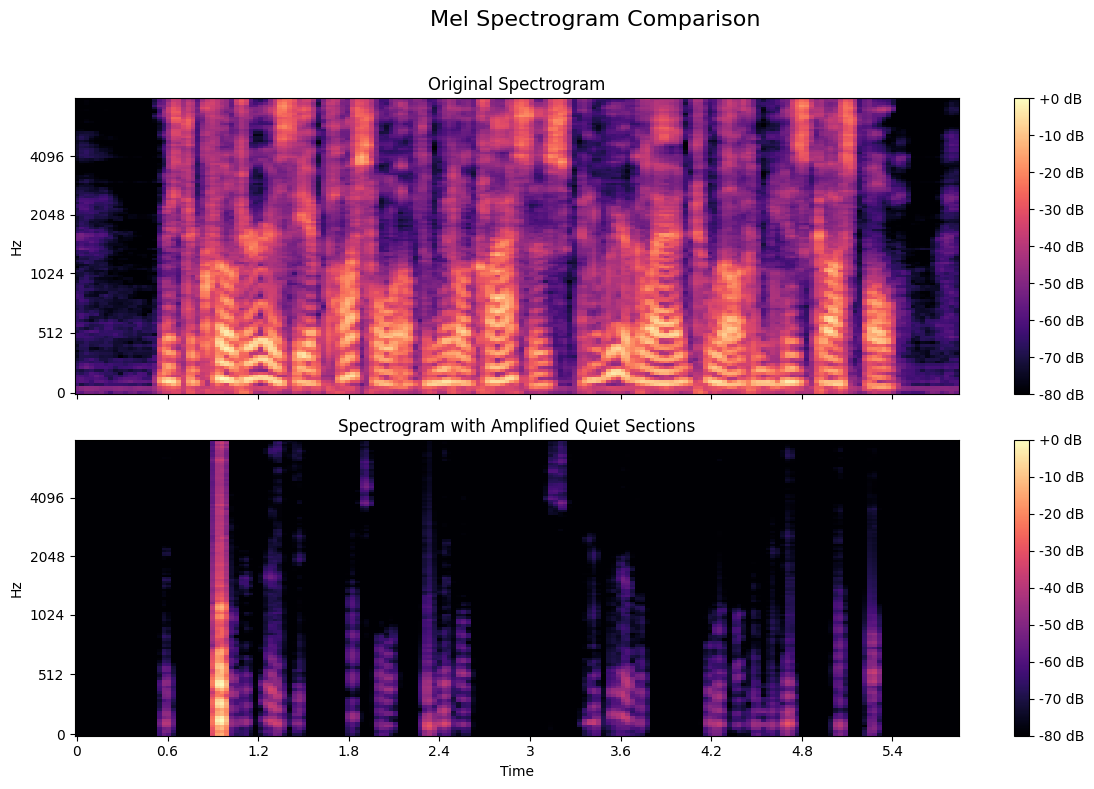

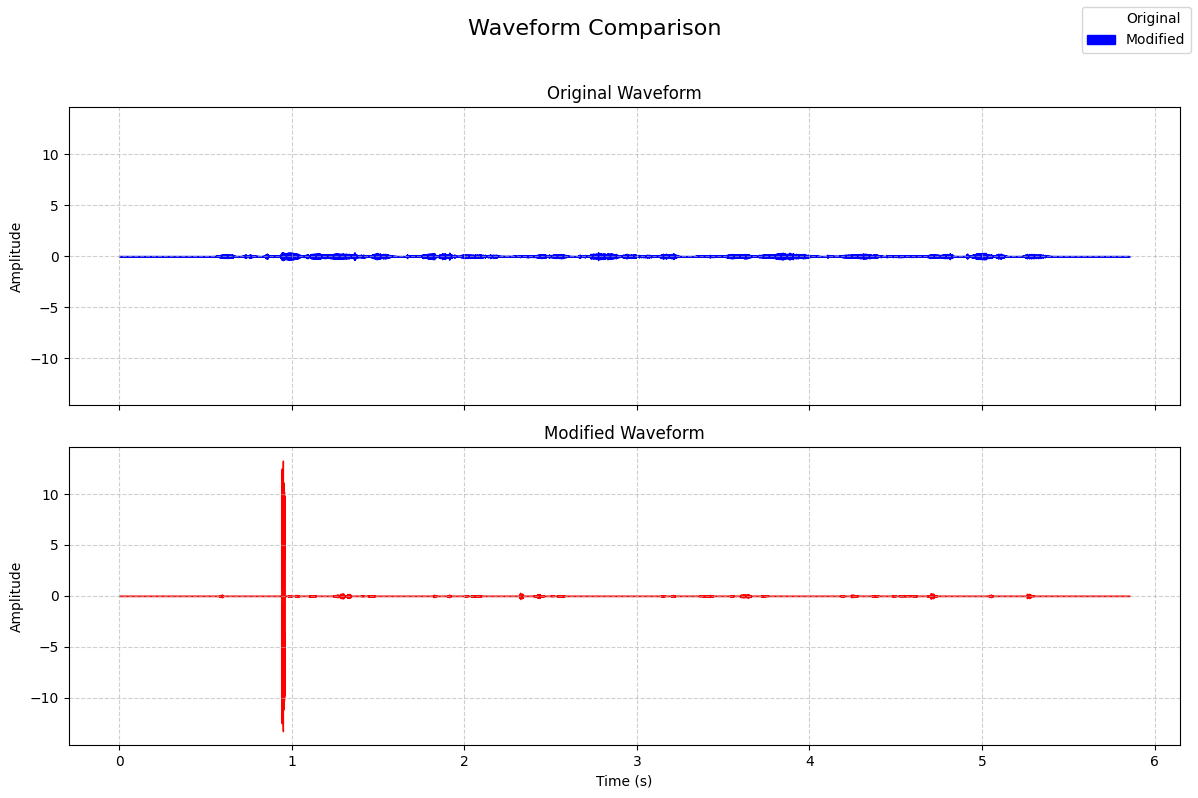

In [24]:
characters = [28,  29,  31,  32,  33,  35,  37,  39,  40,  41,  43,  45,  48,  49,
         50,  53,  57,  58,  59,  61,  62,  63,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  80,  84,  90,  91,  92,  95,  96,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 109, 110, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131,
        132, 133, 136, 142, 143, 147, 152, 154, 155, 156, 157, 158, 168, 169,
        170, 171, 172, 173, 174, 177, 179, 181, 182, 183, 184, 185, 186, 187,
        189, 195, 199, 201, 202, 203, 205, 207, 208, 209, 210, 212, 215, 217,
        221, 224, 226, 227, 228, 229, 230, 231, 232, 234, 237, 238, 239, 241,
        242, 243, 245, 251, 252, 253, 254, 258, 262, 263, 265, 266, 268, 269,
        270, 271]
character_shap_values = [np.zeros((93680,)) for _ in characters]
for idx, char in enumerate(characters):
    for i, timestep in enumerate(shap_values[1][0]):
        character_shap_values[idx][i] = abs(timestep[char])

window_length_ms = 20

num_of_frames = window_length_ms*16

for arr in character_shap_values:
    for idx in range(0,len(arr),num_of_frames):
        mean = np.mean(arr[idx:min(idx+num_of_frames,len(arr))])
        arr[idx:min(idx+num_of_frames,len(arr))] = mean

character_norm_shap_values = [normalize_and_scale_shap(vals,0.80,0.0) for vals in character_shap_values]

#print(norm_m_shap_values.shape)

character_amplified_audio = [audio * vals for vals in character_norm_shap_values]

amplified_audio = sum(character_amplified_audio)/len(character_amplified_audio) * 10
S_amplified_audio = librosa.feature.melspectrogram(y=amplified_audio, sr=16000, n_fft=2048, hop_length=512)
S_audio = librosa.feature.melspectrogram(y=audio, sr=16000, n_fft=2048, hop_length=512)
sf.write("m_amplified_audio.wav", amplified_audio, 16000)
plot_spectrograms(S_audio, S_amplified_audio, sr=16000)
plot_waveforms(audio, amplified_audio*5, sr=16000)

In [18]:
shap_values.tofile("shap_values_1.npy")